## metrics & merge:
- calc a distance, avg. speed?, directionality (N,E,S,W) 
- merge to socio-demographic data?

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
import seaborn as sns

%matplotlib inline

In [2]:
gdf = gpd.read_file("../app_route_data/trajets_mtl_trajet_2017.shp", encoding='utf-8') # utf-8 needed to read french letters

In [3]:
gdf.head()

,id_trip,mode,purpose,starttime,endtime,geometry
0,1547,None,None,2017-09-18 04:16:58UTC,2017-09-18 04:26:26UTC,"LINESTRING (-73.651166 45.544501, -73.65122700..."
1,308312,None,None,2017-09-18 06:17:46UTC,2017-09-18 06:58:49UTC,"LINESTRING (-73.650987 45.544496, -73.651011 4..."
2,384772,None,None,2017-09-18 09:30:24UTC,2017-09-18 10:17:28UTC,"(LINESTRING (-73.832869 45.636068, -73.831779 ..."
3,150744,car,pick_up_a_person,2017-09-18 10:02:50UTC,2017-09-18 10:17:12UTC,"LINESTRING (-73.646385 45.54629, -73.646064999..."
4,199011,None,None,2017-09-18 10:18:40UTC,2017-09-18 10:27:44UTC,"(LINESTRING (-73.74549500000001 45.55839, -73...."


In [4]:
gdf['starttime'] = pd.to_datetime(gdf['starttime'])
gdf['endtime'] = pd.to_datetime(gdf['endtime'])

In [5]:
gdf['journeytime'] = gdf['endtime'] - gdf['starttime']

In [6]:
gdf['journeytime'] = gdf.journeytime.apply(lambda tm: tm.seconds)

In [7]:
gdf.journeytime.describe()

count    185285.000000
mean       1531.031454
std        1487.144484
min           1.000000
25%         576.000000
50%        1164.000000
75%        2049.000000
max       83858.000000
Name: journeytime, dtype: float64

Text(0.5, 0, 'journey time (mins)')

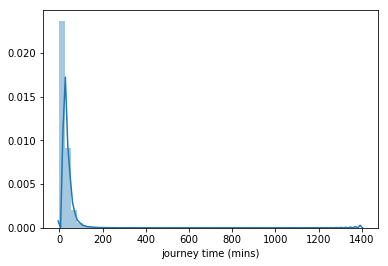

In [8]:
sns.distplot(gdf.journeytime/60,hist=True)
plt.xlabel("journey time (mins)")

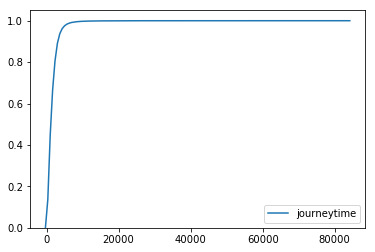

In [9]:
sns.kdeplot(gdf.journeytime,cumulative=True)

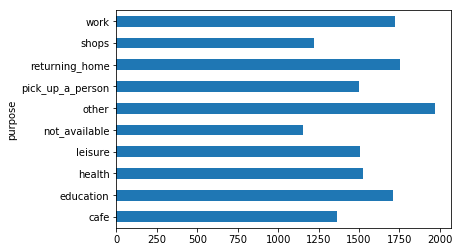

In [12]:
gdf.groupby(["purpose"]).mean().journeytime.plot.barh()